In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-fc96eba6-e9b1-82e0-9ec4-8bc803e3c182)


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade

     |████████████████████████████████| 24.1 MB 2.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Importing Dependencies

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,f1_score,roc_auc_score,roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import LinearSVC
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV


# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import optimizers


# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


## Importing Stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Settings

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
#TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading in the File

Make sure to include the correct path of the file.

In [ ]:
# dataset_path = "/content/drive/MyDrive/AI2-Final Project/training.1600000.processed.noemoticon.csv"
dataset_path = "/content/drive/MyDrive/SentimentAnalysis/training.1600000.processed.noemoticon.csv"

print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

Open file: /content/drive/MyDrive/SentimentAnalysis/training.1600000.processed.noemoticon.csv


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Taking subset of the Data

In [ ]:
from sklearn.model_selection import train_test_split
#x_train, df2, y_train, df3 = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.0625, random_state=19, stratify=df['target'])
x_train, df2, y_train, df3 = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.125, random_state=19, stratify=df['target'])

df1 = pd.concat([df3, df2], axis = 1)

In [ ]:
df1.head()

,target,ids,date,flag,user,text
513467,0,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...
317873,0,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...
1106322,4,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...
430836,0,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...
1211267,4,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?


In [ ]:
df1.shape

(200000, 6)

# Map Label to String

In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df1.target = df1.target.apply(lambda x: decode_sentiment(x))

CPU times: user 73.2 ms, sys: 1.82 ms, total: 75 ms
Wall time: 120 ms


In [ ]:
df1.head()

,target,ids,date,flag,user,text
513467,NEGATIVE,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...
317873,NEGATIVE,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...
1106322,POSITIVE,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...
430836,NEGATIVE,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...
1211267,POSITIVE,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?


## Check distribution of sentiments

Text(0.5, 1.0, 'Dataset labels distribuition')

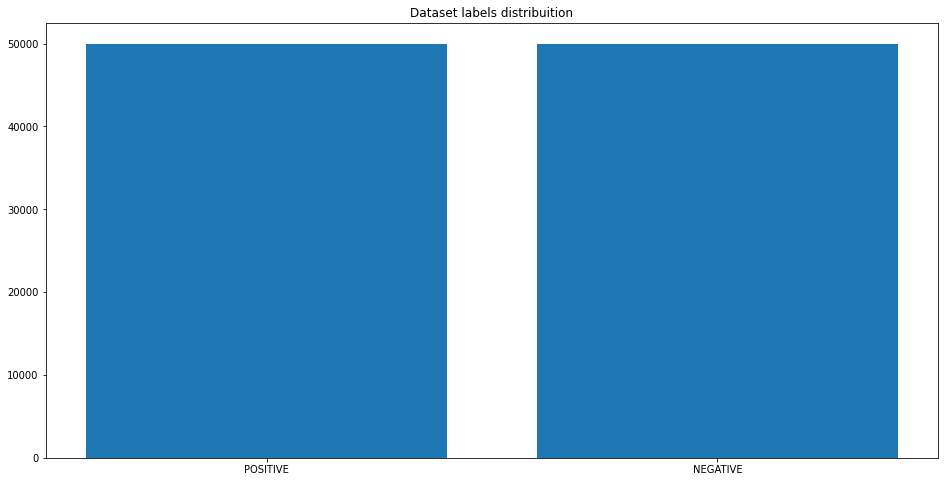

In [ ]:
target_cnt = Counter(df1.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Preprocessing the dataset

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

## Text Preprocessing

In [ ]:
# def preprocess(text, stem=False):
#     # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#     tokens = []
#     for token in text.split():
#         if token not in stop_words:
#             if stem:
#                 tokens.append(stemmer.stem(token))
#             else:
#                 tokens.append(token)
#     return " ".join(tokens)

In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
def preprocess_lemma(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
          tokens.append(lem.lemmatize(token))
            
    return " ".join(tokens)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
%%time
df1['text_clean'] = df1.text.apply(lambda x: preprocess_lemma(x))

CPU times: user 8.8 s, sys: 203 ms, total: 9 s
Wall time: 8.96 s


Display Tweet Text- Before and After Processing

In [ ]:
pd.options.display.max_colwidth = int(df1['text'].str.len().max()) + 1
print(df1.iloc[0:5,5:7])

                                                                                                         text  \
513467                                              Yay for Jon and Kate + 8! boo for having to work at 10am    
317873   @TimothyH2O sorry about last night I would have stayed up with you but you weren't here when I left    
1106322                                               Good Morning my Twitter Loves.....Have a wonderful day    
430836                         @jamesheart24 I am great.. 'Revising' for my last exam  you done all of yours?   
1211267                                                     @AmyyVee wehehehehe sorry.... :| ) So whats new?    

                                      text_clean  
513467              yay jon kate 8 boo work 10am  
317873        sorry last night would stayed left  
1106322  good morning twitter love wonderful day  
430836             great revising last exam done  
1211267               wehehehehe sorry whats new  


## Making Utitlity functions for Model diagnostics and comparison


In [ ]:

def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print('Train confusion matrix is: ',)
  print(confusion_matrix(y_train, predicted_class_train))

  print()
  print('Test confusion matrix is: ')
  print(confusion_matrix(y_test, predicted_class))
  print()
  print(classification_report(y_test,predicted_class)) 
  print() 
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print()
  train_auc = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
  test_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

  print("Train ROC-AUC score: ", train_auc)
  print("Test ROC-AUC score: ", test_auc)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(lr_recall, lr_precision)
  ax1.set(xlabel="Recall", ylabel="Precision")

  plt.subplots_adjust(left=0.5,
                    bottom=0.1, 
                    right=1.5, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  print()
  print('Are under Precision-Recall curve:', lr_f1)
  
  fpr, tpr, _ = roc_curve(y_test, test_probs)


  ax2.plot(fpr, tpr)
  ax2.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

  print("Area under ROC-AUC:", lr_auc)
  return train_accuracy, test_accuracy, train_auc, test_auc



def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model
  


In [ ]:
def model_Evaluate(model):
# Predict values for Test dataset
  y_pred = model.predict(x_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Base SVM model with TF-IDF </h1>
</div>


In [ ]:
def value(v):
    if v == 'POSITIVE':
        return 1
    else:
        return 0

In [ ]:
df1['Target_Level'] = df1.apply(lambda x: value(x.target), axis = 1)

In [ ]:
df1.head()

,target,ids,date,flag,user,text,text_clean,Target_Level
513467,NEGATIVE,2190392801,Tue Jun 16 02:35:58 PDT 2009,NO_QUERY,ericaaviles,Yay for Jon and Kate + 8! boo for having to wo...,yay jon kate 8 boo work 10am,0
317873,NEGATIVE,2002701375,Tue Jun 02 04:56:34 PDT 2009,NO_QUERY,janine_j9,@TimothyH2O sorry about last night I would hav...,sorry last night would stayed left,0
1106322,POSITIVE,1971410827,Sat May 30 07:02:48 PDT 2009,NO_QUERY,CandisDanielle,Good Morning my Twitter Loves.....Have a wonde...,good morning twitter love wonderful day,1
430836,NEGATIVE,2064416725,Sun Jun 07 06:12:25 PDT 2009,NO_QUERY,Portiaism,@jamesheart24 I am great.. 'Revising' for my l...,great revising last exam done,0
1211267,POSITIVE,1989134863,Mon Jun 01 00:27:37 PDT 2009,NO_QUERY,fadedmoon,@AmyyVee wehehehehe sorry.... :| ) So whats new?,wehehehehe sorry whats new,1


## TF-IDF Vectorizer

In [ ]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df1.text_clean)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df1['Target_Level'], test_size= 0.3, random_state=42)


## Models



## SVM

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     15004
           1       0.74      0.76      0.75     14996

    accuracy                           0.74     30000
   macro avg       0.74      0.74      0.74     30000
weighted avg       0.74      0.74      0.74     30000



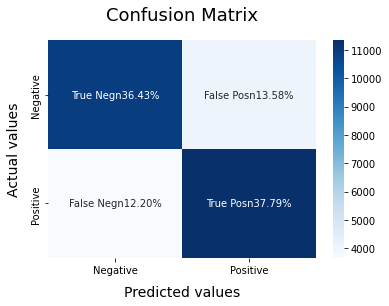

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(x_test)

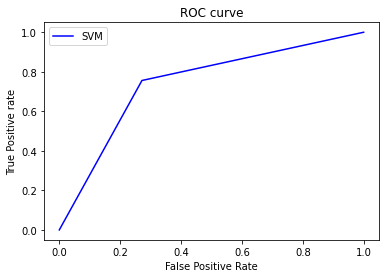

In [ ]:

fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred2, pos_label=1)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
plt.plot(fpr1, tpr1, linestyle='-',color='blue', label='SVM')
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
auc_score1 = roc_auc_score(y_test, y_pred2)

auc_score1

0.7421703372210018

> With increase in FPR, TPR also increases.

> With increase in recall, precision decreases.

# Optimized SVM - Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters ={
    "C":[0.1, 1, 10],
    "kernel":['rbf'],
    "gamma":['auto']
}

svm_optimal = grid_search(svm.SVC(probability=True), parameters, x_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=11.3min
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=11.3min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=11.4min
[CV] END ........................C=1, gamma=auto, kernel=rbf; total time=11.5min
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=11.3min
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=11.5min


Best parameters are: 
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
# from sklearn.model_selection import GridSearchCV
 
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10],
#               'kernel': ['rbf'],
#               'gamma': [1, 0.1, 0.01]
#               }
 
# svm_optimal = grid_search(LinearSVC(), param_grid, x_train, y_train)
 
# fitting the model for grid search
# grid.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     15004
           1       0.50      1.00      0.67     14996

    accuracy                           0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.33     30000



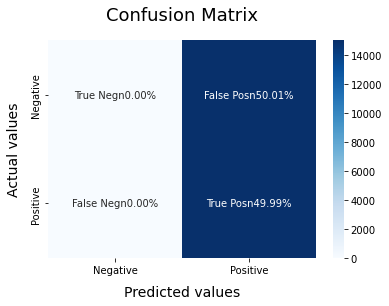

In [ ]:
model_Evaluate(svm_optimal)

In [ ]:
y_pred3 = svm_optimal.predict(x_test)

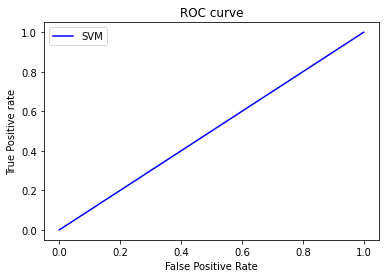

In [ ]:

fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred3, pos_label=1)
random_probs1 = [0 for i in range(len(y_test))]
p_fpr1, p_tpr1, _ = roc_curve(y_test, random_probs1, pos_label=1)
plt.plot(fpr2, tpr2, linestyle='-',color='blue', label='SVM')
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
auc_score2 = roc_auc_score(y_test, y_pred3)
auc_score2

0.5

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters ={
    "C":[0.1, 1, 10],
    "kernel":['linear'],
    "gamma":['auto']
}

svm_optimal = grid_search(svm.SVC(probability=True), parameters, x_train, y_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 8.1min
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time= 8.0min
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=11.1min
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=11.5min
[CV] END ....................C=10, gamma=auto, kernel=linear; total time=43.9min
